In [1]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import base
from IPython.display import display, HTML
import math
import time
import utm
from datetime import datetime, timedelta
import matplotlib.animation as animation

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor


ModuleNotFoundError: No module named 'utm'

  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6094 sha256=2c70618a3d73a60bac452e8f816735d344e82646c9e0f2e0559795dcc47de72f
  Stored in directory: /Users/axellew/Library/Caches/pip/wheels/65/e2/d8/878a8cc986641056fbfebefc4d8eb64238a7b6d3426e86b447
Successfully built utm
You should consider upgrading via the '/Users/axellew/Desktop/Axel/Tesis/birds-tracking/py3/bin/python -m pip install --upgrade pip' command.


## Map utils

In [3]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 


global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111



## Entreno el modelo que vamos a usar para predecir

In [4]:
points_recep = sc.read.json('../datos/train-test-by-emission.jsonlines/').rdd

In [6]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [7]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

## Levanto datos de validacion

In [8]:
validation_track = sc.read.csv('../datos/validation_birds_tracks.csv', header=True)

In [9]:
def add_utm_coordinates(row):
    row_dict = row.asDict()
    x, y,_,_ = utm.from_latlon(float(row['Latitud']), float(row['Longitud']))
    row_dict['x'] = x
    row_dict['y'] = y
    return row_dict

def add_timestamp(row):
    row['timestamp'] = '{} {}'.format(
        datetime.strptime(row['Fecha'], '%m/%d/%Y').strftime('%Y-%m-%d'),
        row['Hora']
    )
    return row

In [10]:
validation_track = validation_track.rdd.map(add_utm_coordinates).map(add_timestamp)

In [11]:
validations_list = validation_track.collect()

In [12]:
validation_days = set([e['timestamp'].split()[0] for e in validations_list])
validation_birds = set([int(e['ID']) for e in validations_list])

## Levanto el archivo con las emisiones de los pajaros

In [13]:
birds_recep = sc.read.json('../datos/all-birds-data.jsonlines/').rdd
birds_recep = birds_recep.filter(lambda x: x['timestamp'].split()[0] in validation_days and x['tag_id'] in validation_birds)
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

### Mapa con el movimiento predicho para un pajaro cerca del momento de validacion

In [23]:
validation_track.take(48)[47]

{'ID': '33',
 'Fecha': '1/21/2018',
 'Hora': '5:03:07',
 'Latitud': '-35.1407',
 'Longitud': '-57.38662',
 'Tipo': 'D',
 'x': 464780.69076134166,
 'y': 6111285.263654969,
 'timestamp': '2018-01-21 5:03:07'}

In [104]:
def get_predictions_of_validation_point(validation_point):
    BIRD_TAG_ID = int(validation_point['ID'])
    START_TIME = (
        (datetime.strptime(validation_point['timestamp'], '%Y-%m-%d %H:%M:%S')-timedelta(seconds=60*2))
        .strftime('%Y-%m-%d %H:%M:%S')
    )
    END_TIME = (
        (datetime.strptime(validation_point['timestamp'], '%Y-%m-%d %H:%M:%S')+timedelta(seconds=60*2))
        .strftime('%Y-%m-%d %H:%M:%S')
    )

    single_bird = (
        birds_recep
        .filter(lambda x: x['tag_id'] == BIRD_TAG_ID)
        .filter(lambda x: x['timestamp'] >= START_TIME)
        .filter(lambda x: x['timestamp'] < END_TIME)
    )

    birds_data = pd.DataFrame(single_bird.collect()).drop(columns=[4,5])
    
    predictions = predictor.predict(birds_data)
    return pd.concat([pd.DataFrame(predictions), pd.DataFrame(single_bird.collect())], axis=1).values

In [74]:
for i in range(48):
    try:
        get_predictions_of_validation_point(validation_track.take(48)[i])
        print(i)
    except:
        pass

0
1
2
3
4
6
7
8
31
32
34
35
36
37
38
46
47


In [116]:
vps = [
    normalizer._normalize_positions(validation_track.take(48)[2]),
    normalizer._normalize_positions(validation_track.take(48)[0]),
] 
val_preds = [
    get_predictions_of_validation_point(vps[0]),
    get_predictions_of_validation_point(vps[1])
]

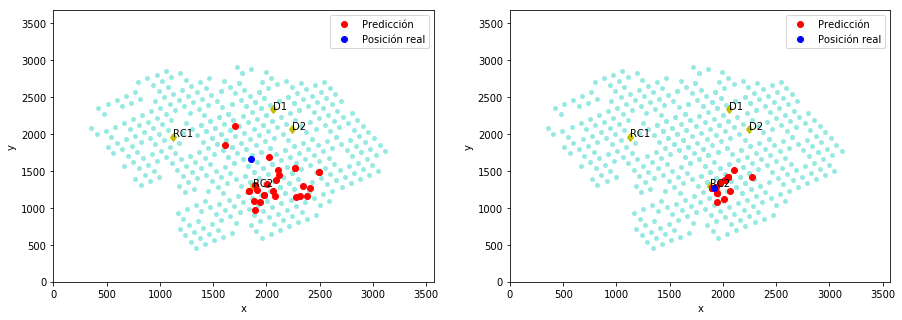

In [117]:
fig, axs = plt.subplots(1,2,figsize=(15,5))


for i in [0,1]:
    predictions = val_preds[i]
    ax = axs[i]
    ax.set_ylim(0,y_f-y_0)
    ax.set_xlim(0,x_f-x_0)
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalizer._normalize_positions).collect())
    ax.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=15, label = None)
    for antenna in range(4):
            pos_antena = posicion_antenas[antenna]
            ax.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
            name = nombre_antenas[antenna]
            ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 


    ax.plot([point[0] for point in predictions], [point[1] for point in predictions], 'go', color='red', label='Predicción')

    ax.plot([vps[i]['x']], [vps[i]['y']], 'go', color='blue', label='Posición real') # plot real position

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
fig.savefig('EjemploPrediccionPuntosValidacion.png')

